In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt # Visualization
import warnings # Supress warnings
warnings.filterwarnings('ignore')

In [ ]:
from keras.models import Sequential
from keras.layers import *
from keras.callbacks import ModelCheckpoint
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam
from keras.models import load_model

In [ ]:
df = pd.read_csv("./files/scaled_m.csv", index_col=0)
df.index = pd.to_datetime(df.index, format = '%Y-%m-%d')
df

In [70]:
depth = df['Depth_to_Groundwater']
temp = df['Temperature']
rain = df['Rainfall']
drain = df['Drainage_Volume']
hydro = df['River_Hydrometry']

In [71]:
WINDOW_SIZE = 5
TEST_SIZE = 0.4
VAL_SIZE = 0.3

In [72]:
def init_model():
    model = Sequential()
    model.add(InputLayer((5, 1)))
    model.add(LSTM(64))
    tf.keras.layers.Dropout(0.2),
    model.add(Dense(8, 'relu'))
    model.add(Dense(1, 'linear'))
    model.summary()
    return model

In [73]:
def df_to_X_y(df, window_size=5):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [[a] for a in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size]
        y.append(label)
    return np.array(X), np.array(y)

In [74]:
def get_sets(series):
    X1, y1 = df_to_X_y(series, WINDOW_SIZE)
    X_train1, y_train1 = X1[:int(len(df.index) * TEST_SIZE)], y1[:int(len(df.index) * TEST_SIZE)]
    X_val1, y_val1 = X1[int(len(df.index) * TEST_SIZE):int(len(df.index) * (TEST_SIZE + VAL_SIZE))], y1[int(len(df.index) * TEST_SIZE):int(len(df.index) * (TEST_SIZE + VAL_SIZE))]
    X_test1, y_test1 = X1[int(len(df.index) * (TEST_SIZE + VAL_SIZE)):], y1[int(len(df.index) * (TEST_SIZE + VAL_SIZE)):]
    return X1, y1, X_train1, y_train1, X_val1, y_val1, X_test1, y_test1

In [75]:
def train_model(series, checkpoint):
    X1, y1, X_train1, y_train1, X_val1, y_val1, X_test1, y_test1 = get_sets(series)
    model = init_model()
    cp1 = ModelCheckpoint('C:\\Users\\poeppelmann\\DataspellProjects\\dsProject\\LSTM_models\\'+checkpoint, save_best_only=True)
    model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])
    model.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=30, callbacks=[cp1])
    return model

In [76]:
def model_predict(series, checkpoint, name):
    model = load_model('C:\\Users\\poeppelmann\\DataspellProjects\\dsProject\\LSTM_models\\'+checkpoint)
    X1, y1, X_train1, y_train1, X_val1, y_val1, X_test1, y_test1 = get_sets(series)
    train_predictions = model.predict(X_train1).flatten()
    val_predictions = model.predict(X_val1).flatten()
    test_predictions = model.predict(X_test1).flatten()
    predictions = np.concatenate((train_predictions, val_predictions, test_predictions))
    results = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y1}, index=df.index[5:])
    results.to_csv('predictions/'+name)
    return results

In [77]:
def calc_metrics(name):
    # Step 1: Load prediction csv
    results = pd.read_csv('predictions/LSTM/'+name, index_col=0)
    results.index = pd.to_datetime(results.index, format = '%Y-%m-%d')

    # Step 2: Calculate the differences between the predicted and actual values
    results['Difference'] = results['Actuals'] - results['Predictions']

    # Step 3: Calculate squared differences for RMSE
    results['Squared_difference'] = results['Difference'] ** 2

    # Step 4: Calculate absolute differences for MAE and MAPE
    results['Absolute_difference'] = np.abs(results['Difference'])
    results['Absolute_percentage_difference'] = np.abs(results['Difference'] / results['Actuals'])

    # Step 5: Compute the metrics
    rmse = np.sqrt(results['Squared_difference'].mean())
    mae = results['Absolute_difference'].mean()
    mape = results['Absolute_percentage_difference'].mean() * 100  # to get the percentage
    return rmse, mae, mape

In [ ]:
metrics = {}
num=0
for column in df.columns:
    checkpoint = num+'\\'+column
    series = df[column]
    name = num+'/'+column+'.csv'
    train_model(series,checkpoint)
    results = model_predict(series, checkpoint, name)
    rmse, mae, mape = calc_metrics(name)
    metrics[column] = {
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape
    }
metrics_df = pd.DataFrame(metrics)
metrics_df.to_csv('metrics/LSTM/'+num+'.csv')
print(metrics_df)

In [81]:
import winsound
winsound.Beep(2500,1000)

In [48]:
def plot_predictions(df, start=0, end=4194):
    plt.plot(df['Predictions'][start:end], label="Prediction")
    plt.plot(df['Actuals'][start:end], label="Actual")
    plt.legend()
    plt.show()
    return

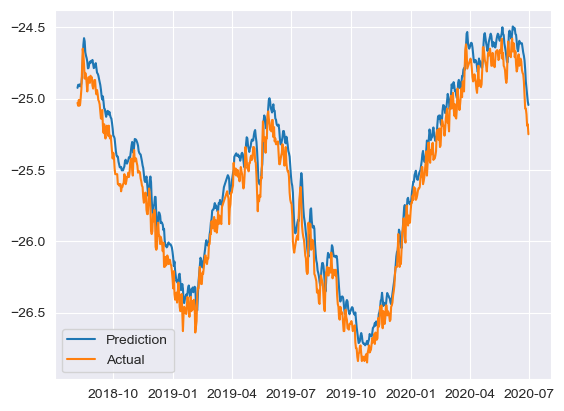

In [52]:
plot_predictions(results, 3500, 4200)